# Importing relevant libraries

In [1]:
import torch
import torch.functional as F
import torch.nn as nn
import tensorflow as tf

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
import os

In [2]:
torch.__version__

'2.4.0+cpu'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

# Filtering the text

In [9]:
# Read the file
file_path = 'assets\leo-tolstoy-war-and-peace.txt'

# Open and read the contents of the file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

filtered_text = re.sub(r'-', ' ', text)
filtered_text = re.sub('[^a-zA-Z0-9 \.\n]', '', filtered_text)
filtered_text = filtered_text.lower()

lines=filtered_text.split(".")
words=['.']
for l in lines:
    for w in l.split():
        if (len(w)>0):
            words.append(w)
words=list(pd.Series(words).unique())

print("Total no. of lines: ", len(lines))
print("Total unique words: ", len(words))

Total no. of lines:  30588
Total unique words:  17877


In [10]:
#Mapping from words to integers and vice versa
stoi={s:i for i,s in enumerate(words)}
itos={i:s for s,i in stoi.items()}
print(len(itos))

17877


# Generating the labelled dataset

In [11]:
# Hyperparameter
block_size=5 # context_length: how many words do we take to predict the next one

# X and Y matrices to store the data for training
# X stores the half lines
# Y stores the next word
X,Y=[],[]
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for l in lines:
  context=[0]*block_size
  word_l=l.split()

  for i in range(len(word_l)):
    ix=stoi[word_l[i]]
    X.append(context)
    Y.append(ix)
#     print(' '.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

    if (i==len(word_l)-1):
        ix=stoi['.']
        X.append(context)
        Y.append(ix)
#         print(' '.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)


X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([592621, 5]), torch.Size([592621]), torch.int64, torch.int64)

# Defining the model

In [12]:
emb_dim = 64 # Hyperparameter

# Embedding layer
emb=torch.nn.Embedding(len(stoi),emb_dim).to(device)
print(emb)


Embedding(17877, 64)


In [13]:
class Next_Word_Predictor(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_dim, activation_fn, seed_value):
        super().__init__()
        self.block_size = block_size
        self.hyperparams = {'block_size':self.block_size, 'emb_dim':emb_dim, 'hidden_dim':hidden_dim, 'activation_fn':activation_fn, 'seed_value':seed_value}
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.linear1 = nn.Linear(block_size * emb_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)
         
        if activation_fn == 'sigmoid':
            self.activation = torch.sigmoid  
        else:
            self.activation = torch.relu 

    def forward(self, x):
        # Embedding layer
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  
        
        # Hidden layer
        x = self.linear1(x)
        x = self.activation(x)
        
        # Output layer
        x = self.linear2(x)
        
        return x


In [15]:
#Create an instance of the model
untrained_model = Next_Word_Predictor(15, len(stoi),64,  1024, 'relu', 42).to(device)
print(untrained_model.emb.weight.detach().cpu().numpy())

[[-1.045815   -0.415348   -0.92003495 ...  0.18163535 -0.9936079
  -1.3196248 ]
 [-0.12519594 -0.03575947 -0.40205345 ...  0.00662351  2.1320126
  -0.2688297 ]
 [-0.4748262  -1.8086654  -1.07908    ... -0.31677532 -0.93360144
  -1.193071  ]
 ...
 [-0.4584335   2.5469086  -0.8772893  ... -1.6398257  -0.14694174
   0.94348824]
 [ 1.7602884   0.06179945  0.22660306 ... -1.4878341   1.0641927
  -0.3092286 ]
 [-0.47907117  1.5366445   0.13298173 ... -0.03557444 -0.46106726
   0.6421817 ]]


In [17]:
# Import the watermark library
from watermark import watermark

# Printing versions of libraries used
%load_ext watermark
%watermark -v -p torch,numpy,pandas,scikit-learn,seaborn,matplotlib,tensorflow

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.19.0

torch       : 2.4.0
numpy       : 1.26.2
pandas      : 2.2.0
scikit-learn: 1.4.1.post1
seaborn     : 0.13.2
matplotlib  : 3.8.2
tensorflow  : 2.16.1



# Training the model

In [20]:
def train_model(X, Y, block_size, emb_dim, vocab_size, hidden_dim, activation_fn, seed_value, device, batch_size=1024, epochs=21, print_every=10):
    """
    Train the model with the specified seed value.
    
    Arguments:
    X -- training data (input features)
    Y -- training data (labels)
    block_size -- context size for input sequence
    emb_dim -- embedding dimension for the model
    vocab_size -- the size of the vocabulary
    hidden_dim -- the size of the hidden layer
    activation_fn -- the activation function to use ('relu', 'tanh', 'sigmoid')
    seed_value -- the seed value for reproducibility
    device -- device to run the training on ('cpu' or 'cuda')
    batch_size -- the size of each mini-batch (default: 1024)
    epochs -- number of training epochs (default: 2000)
    print_every -- print loss after every 'n' epochs (default: 10)
    """
    
    torch.manual_seed(seed_value)

    model = Next_Word_Predictor(block_size, vocab_size, emb_dim, hidden_dim, activation_fn, seed_value).to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        
        # Mini-batch training
        for i in range(0, X.shape[0], batch_size):
            x = X[i:i + batch_size].to(device)
            y = Y[i:i + batch_size].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % print_every == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}')
    
    return model


In [21]:
vocab_size = len(stoi)
# Some other hyperparameters
hidden_dim = 1024
activation_fn = 'relu' 
seed_value = 42 

In [22]:
model = train_model(X, Y, block_size, emb_dim, vocab_size, hidden_dim, activation_fn, seed_value, device)

Epoch 0: Loss = 6.116387367248535
Epoch 10: Loss = 1.7054368257522583
Epoch 20: Loss = 1.1600825786590576


In [23]:
# Saving the model

torch.save(model, 'model_variant_1.pth')

# Generating Predictions

In [49]:
# # Generate names from trained model

# def generate_next_words(model, itos, stoi, content, seed_value, k, max_len=10):
#     torch.manual_seed(seed_value)
    
#     block_size = model.block_size
#     context = content.lower()
#     context = re.sub('[^a-zA-Z0-9 \.]', '', context)
#     context = re.sub('\.', ' . ', context)
#     word_c = context.split()
#     context = []
#     for i in range(len(word_c)):
#         try:
#             if stoi[word_c[i]]:
#                 context.append(word_c[i])
#         except:
#             continue
            
#     context = [stoi[w] for w in context]
               
#     if len(context) <= block_size:
#         context = [0] * (block_size - len(context)) + context
#     elif len(context) > block_size:
#         context = context[-block_size:]

#     for i in range(k):
#         x = torch.tensor(context).view(1, -1).to(device)
#         y_pred = model(x)
#         logits = y_pred
        
#         ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
#         word = itos[ix]
#         content += " " + word
#         context = context [1:] + [ix]
        
#     return content


In [36]:
# Generate names from trained model

def generate_next_words(model, itos, stoi, content, seed_value, k, max_len=10):
    torch.manual_seed(seed_value)
    
    block_size = model.block_size
    context = content.lower()
    context = re.sub('[^a-zA-Z0-9 \.]', '', context)
    context = re.sub('\.', ' . ', context)
    word_c = context.split()
    context = []
    for i in range(len(word_c)):
        try:
            if stoi[word_c[i]]:
                context.append(word_c[i])
        except:
            context = [stoi[w] for w in context]
            if len(context) <= block_size:
                context = [0] * (block_size - len(context)) + context
            elif len(context) > block_size:
                context = context[-block_size:]
            x = torch.tensor(context).view(1, -1).to(device)
            y_pred = model(x)
            logits = y_pred

            ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
            word = itos[ix]
            print(word)
            content += " " + word
            context = context [1:] + [ix]
            context = [itos[w] for w in context]
            
    context = [stoi[w] for w in context]
               
    if len(context) <= block_size:
        context = [0] * (block_size - len(context)) + context
    elif len(context) > block_size:
        context = context[-block_size:]

    for i in range(k):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        logits = y_pred
        
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        word = itos[ix]
        print(word)
        content += " " + word
        context = context [1:] + [ix]
        
    return content

In [39]:
# Generate names from trained model

para=""
content=input("Enter some content: ")
k=int(input("Enter no. of words to be generated: "))
para+=generate_next_words(model, itos, stoi, content, seed_value, k)
para+="\n\n"
print(para)

Enter some content:  He is kjdskjskl djklsd
Enter no. of words to be generated:  15


He is kjdskjskl djklsd a man just both or to ask his action as we were relations on things and understood




# Visualization of embeddings

In [51]:
embedding_weights = model.emb.weight.detach().cpu().numpy() #to be used for visualization

In [52]:
from sklearn.cluster import KMeans

# Set the number of clusters (you can experiment with this number)
n_clusters = 10

# Perform K-means clustering on the embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
clusters = kmeans.fit_predict(embedding_weights)

# Create a dictionary to store words grouped by cluster
clustered_words = {i: [] for i in range(n_clusters)}

# Assign words to their respective clusters
for word, idx in stoi.items():
    if idx < embedding_weights.shape[0]:
        cluster = clusters[idx]
        clustered_words[cluster].append(word)

# Print words in each cluster
for cluster, words in clustered_words.items():
    print(f"Cluster {cluster}: {', '.join(words[:10])}")  # Limiting to first 10 words for readability

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: surprisingly, practical, portionless, predicted, sugary, derisive, girchik, justifying, wail, destitution
Cluster 1: applauding, remaining, spontaneously, puffing, clowns, glittered, exposure, hosts, blessing, turks
Cluster 2: cosmography, resented, beseech, prejudice, despise, remounts, acre, dews, disdaining, mud
Cluster 3: regularity, mallet, incompetent, hippolytes, rocked, hillside, philanthropy, raths, rosebushes, massive
Cluster 4: apologies, makar, avenues, vision, cathedrals, pestered, unanimously, compilers, heel, pan
Cluster 5: hips, adducing, taken, qualities, episode, routes, parallel, retrieved, fleissig, workshops
Cluster 6: cleaving, juridical, eyeglass, consistently, wefused, souza, 4th, disparity, volume, gullies
Cluster 7: morands, occurring, correspondingly, masha, flatter, shoe, favorably, purify, assumes, oaths
Cluster 8: jurisprudence, advesawies, probably, cut, disgraced, mare, touches, hopeless, distinctness, sour
Cluster 9: philosophic, bickering, t

In [ ]:
import re
import random
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Group words based on their suffixes
def group_words(itos):
    groups = {
        'pronouns': ['i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'],
        'others': []
    }

    # Add all other words to 'others' group
    for word in itos.values():
        if word not in groups['pronouns']:
            groups['others'].append(word)
    return groups

# Get the grouped words
grouped_words = group_words(itos)

# Select a subset of words for the pronouns group
selected_words = grouped_words['pronouns']  # All pronouns
selected_group_labels = ['pronouns'] * len(grouped_words['pronouns'])  # Label for pronouns

# Step 1: Add all vocabulary words to the selection
all_words = list(itos.values())
selected_words += all_words
selected_group_labels += ['others'] * len(all_words)

# Step 2: Extract the embeddings for the selected words
selected_embeddings = []
selected_word_labels = []

for word in selected_words:
    if word in stoi:  # Ensure the word exists in stoi
        idx = stoi[word]  # Get the index of the word
        selected_embeddings.append(embedding_weights[idx])  # Get the embedding
        selected_word_labels.append(word)  # Save the word for labeling

selected_embeddings = torch.tensor(selected_embeddings)  # Convert to tensor

# Step 3: Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=1)
embeddings_tsne = tsne.fit_transform(selected_embeddings)

# Step 4: Plot the selected words' embeddings
plt.figure(figsize=(12, 10))

# Colors for highlighting
colors = {
    'pronouns': 'red',  # Pronouns in cyan
    'others': 'blue'  # All other words in blue
}

# Plot pronouns in 'cyan' and other words in 'blue'
for group_name, color in colors.items():
    indices = [i for i, label in enumerate(selected_group_labels) if label == group_name]
    plt.scatter(embeddings_tsne[indices, 0], embeddings_tsne[indices, 1], 
                alpha=0.6, label=group_name, color=color, s=50)

# Add legend for pronouns only
plt.legend(title='Word Groups', loc='upper right')
plt.title('t-SNE Visualization of Word Embeddings with Pronouns Highlighted', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True)  # Optional: Add grid for better readability
plt.tight_layout()  # Adjust layout
plt.show()


Number of pronouns: 18


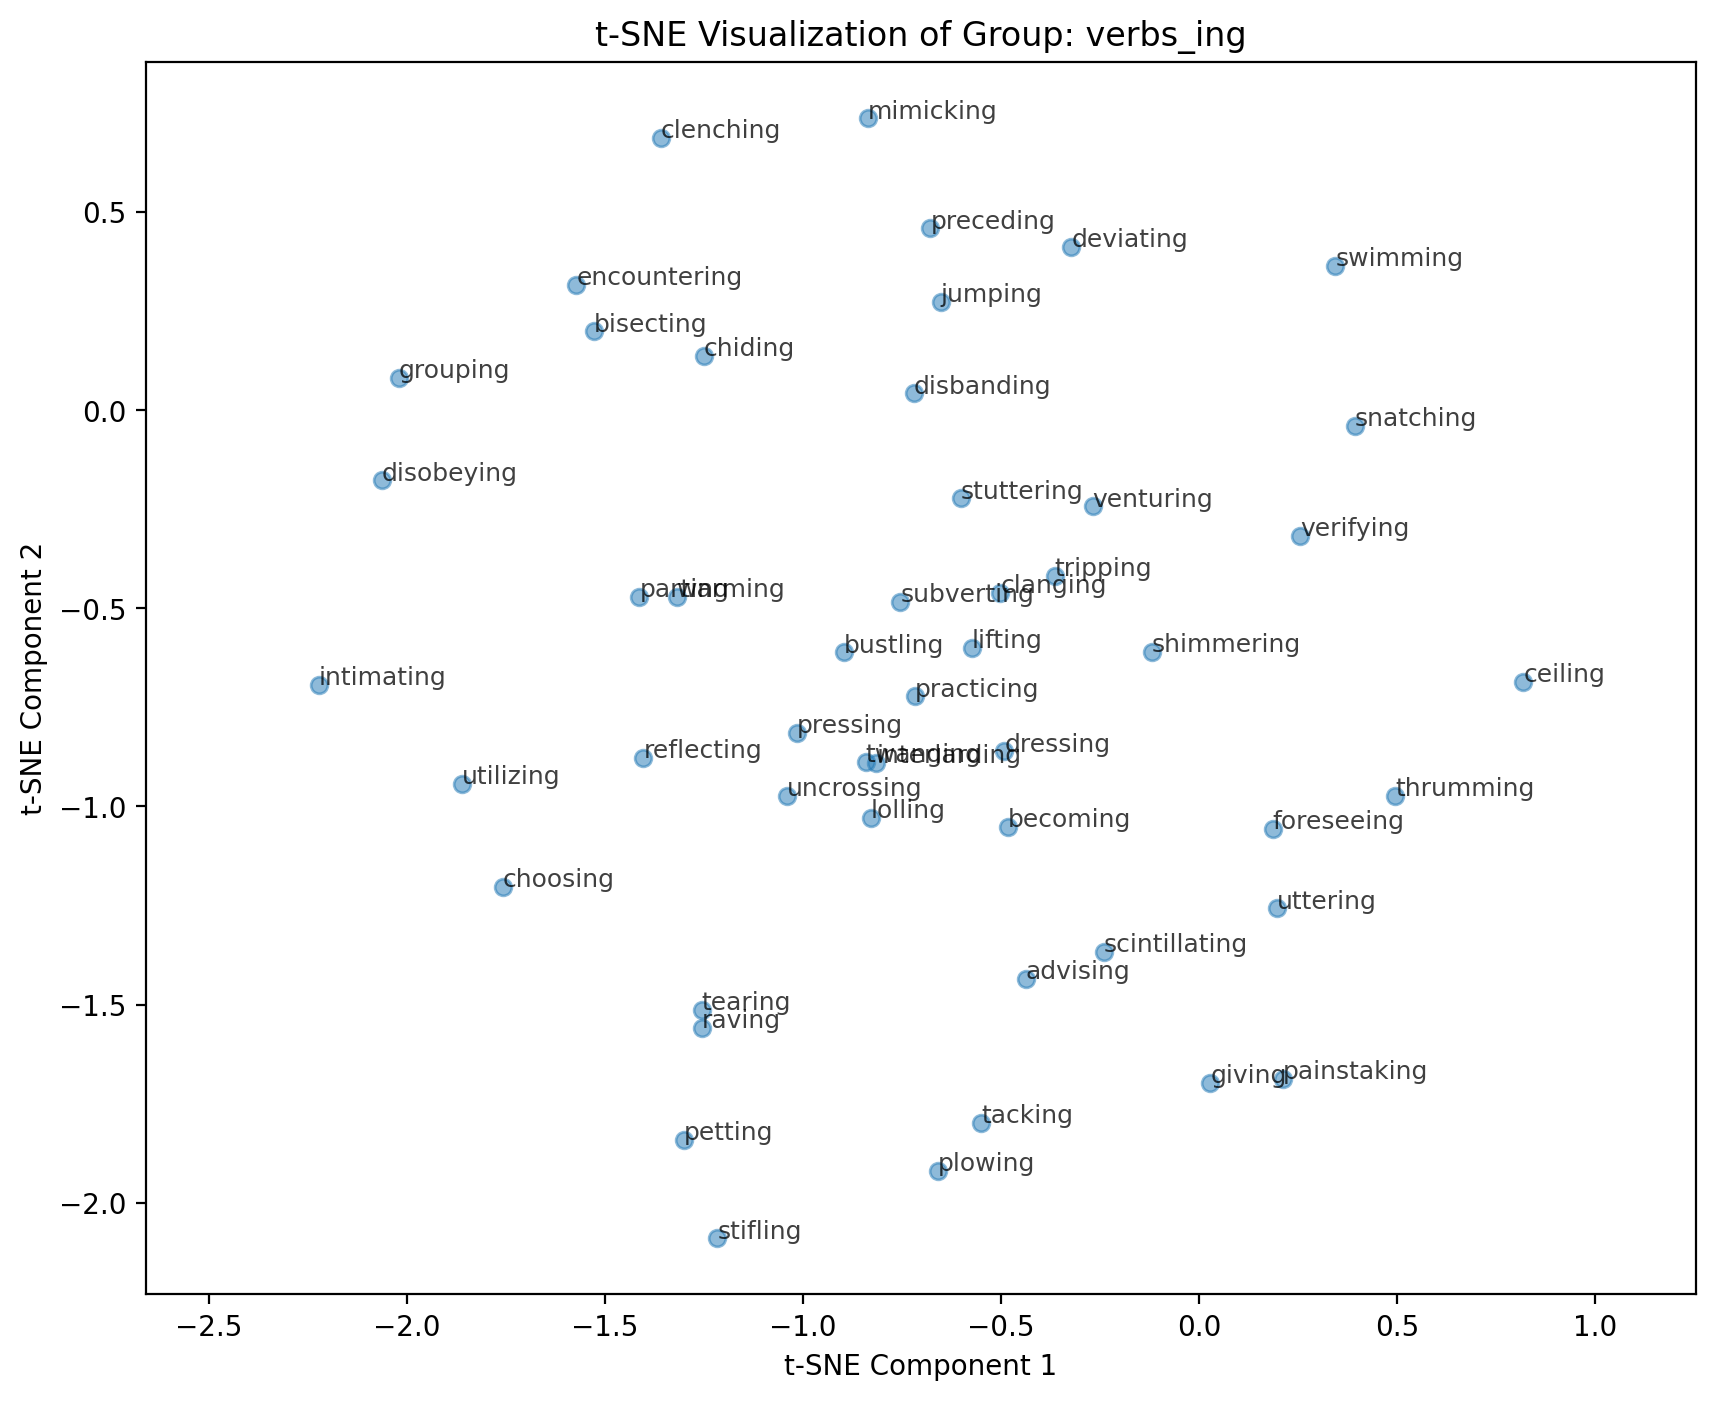

Do you want to proceed to the next group? (y/n):  y


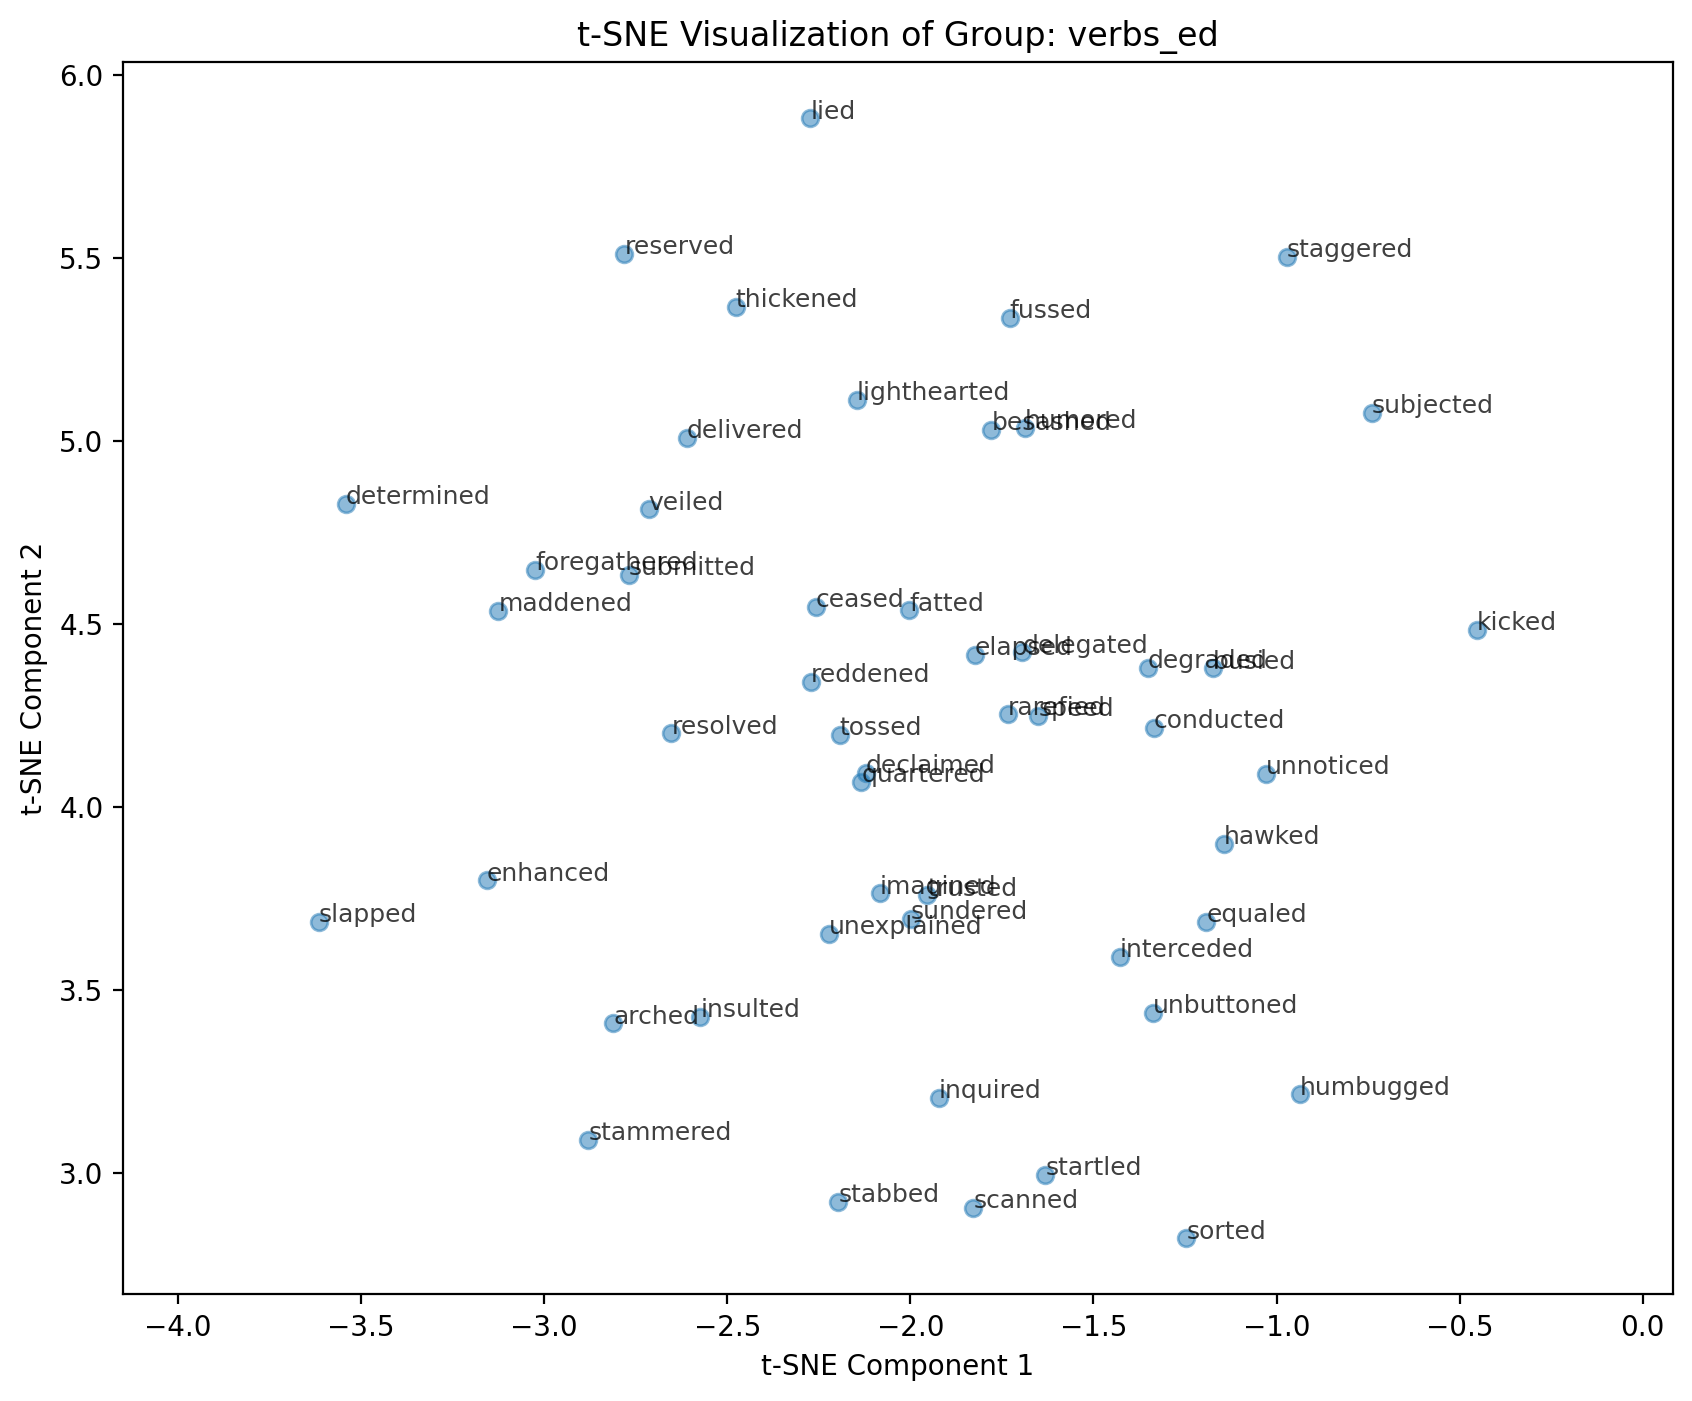

Do you want to proceed to the next group? (y/n):  y


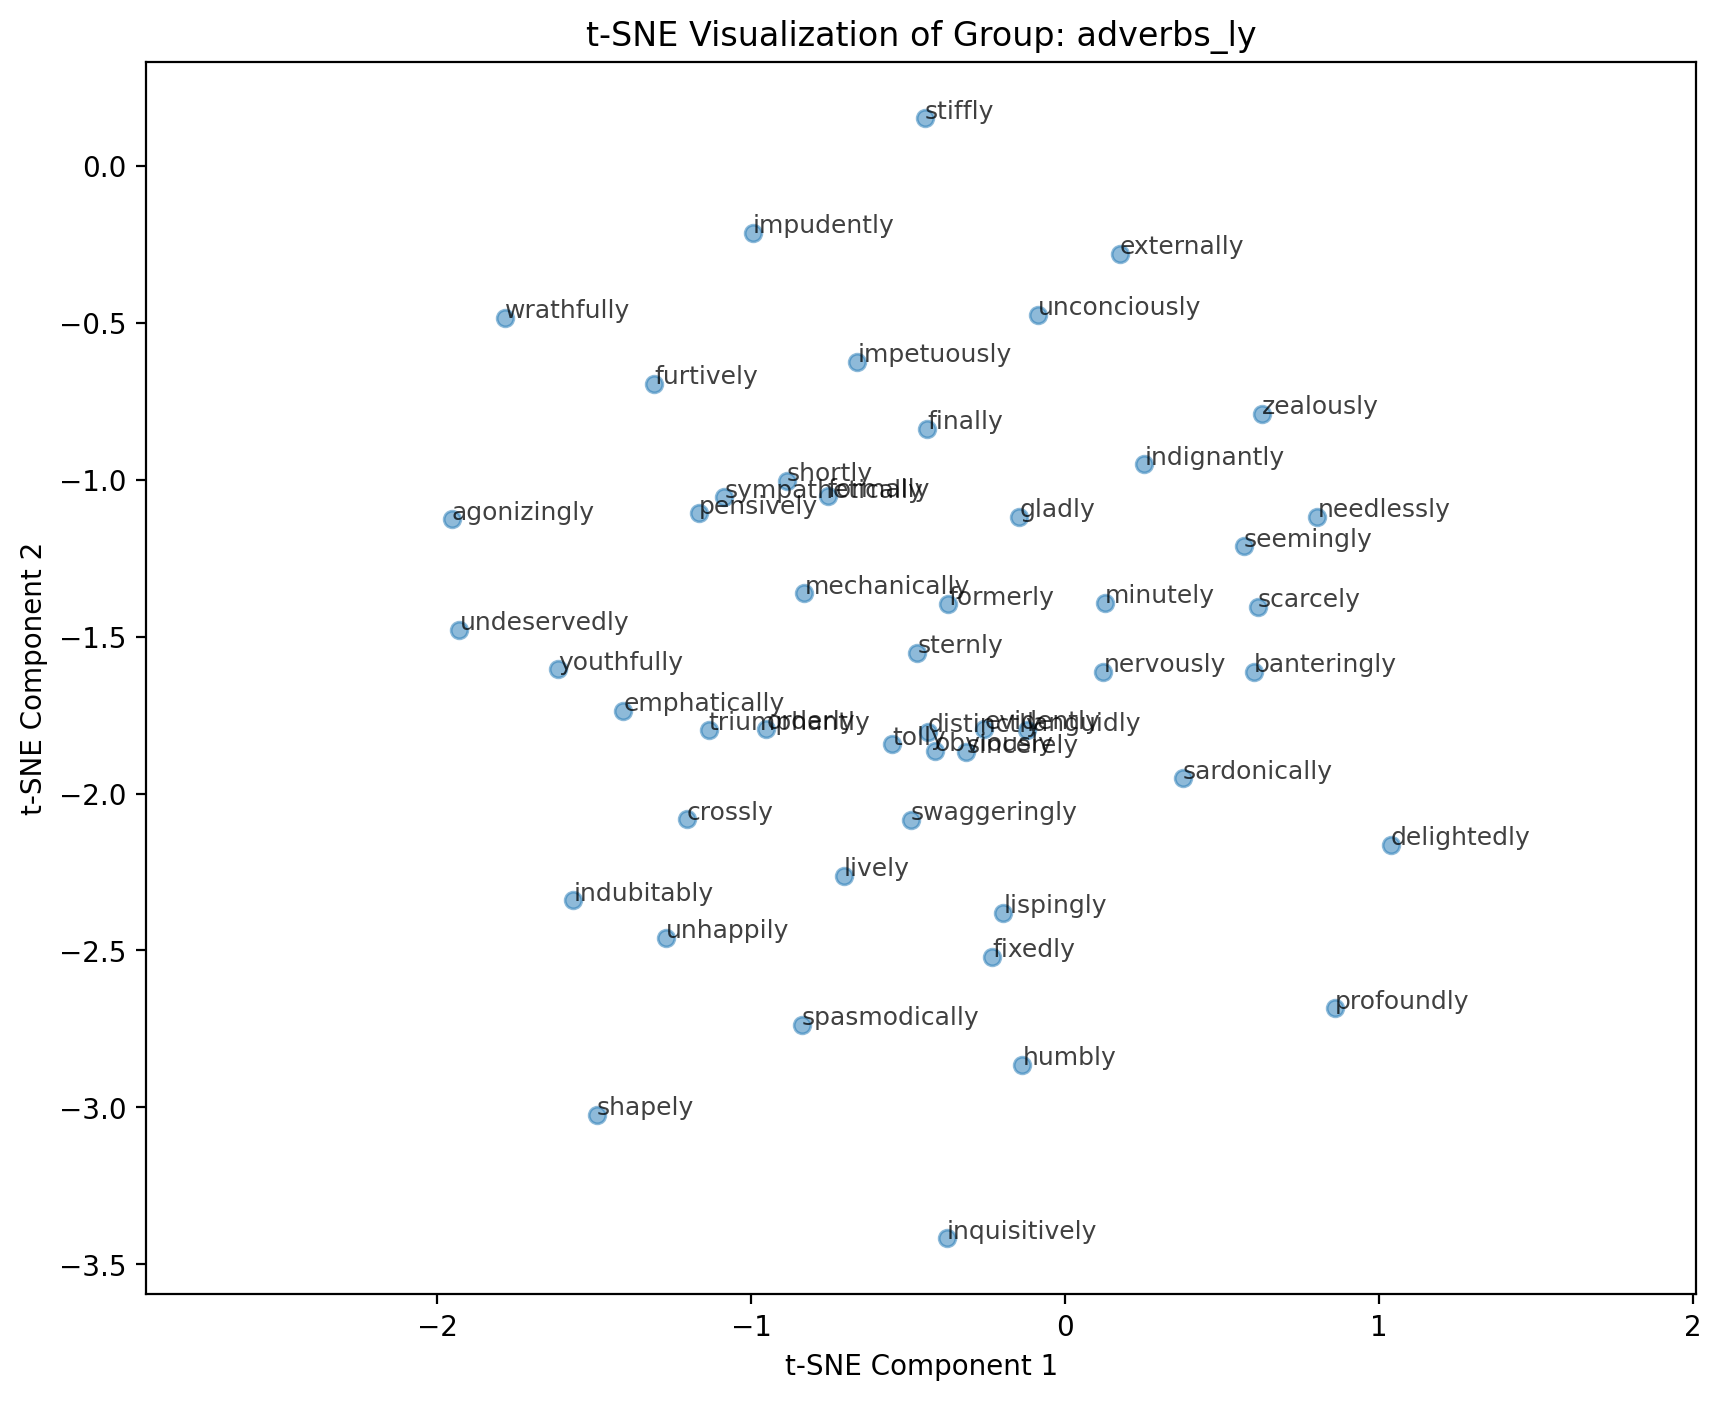

Do you want to proceed to the next group? (y/n):  y


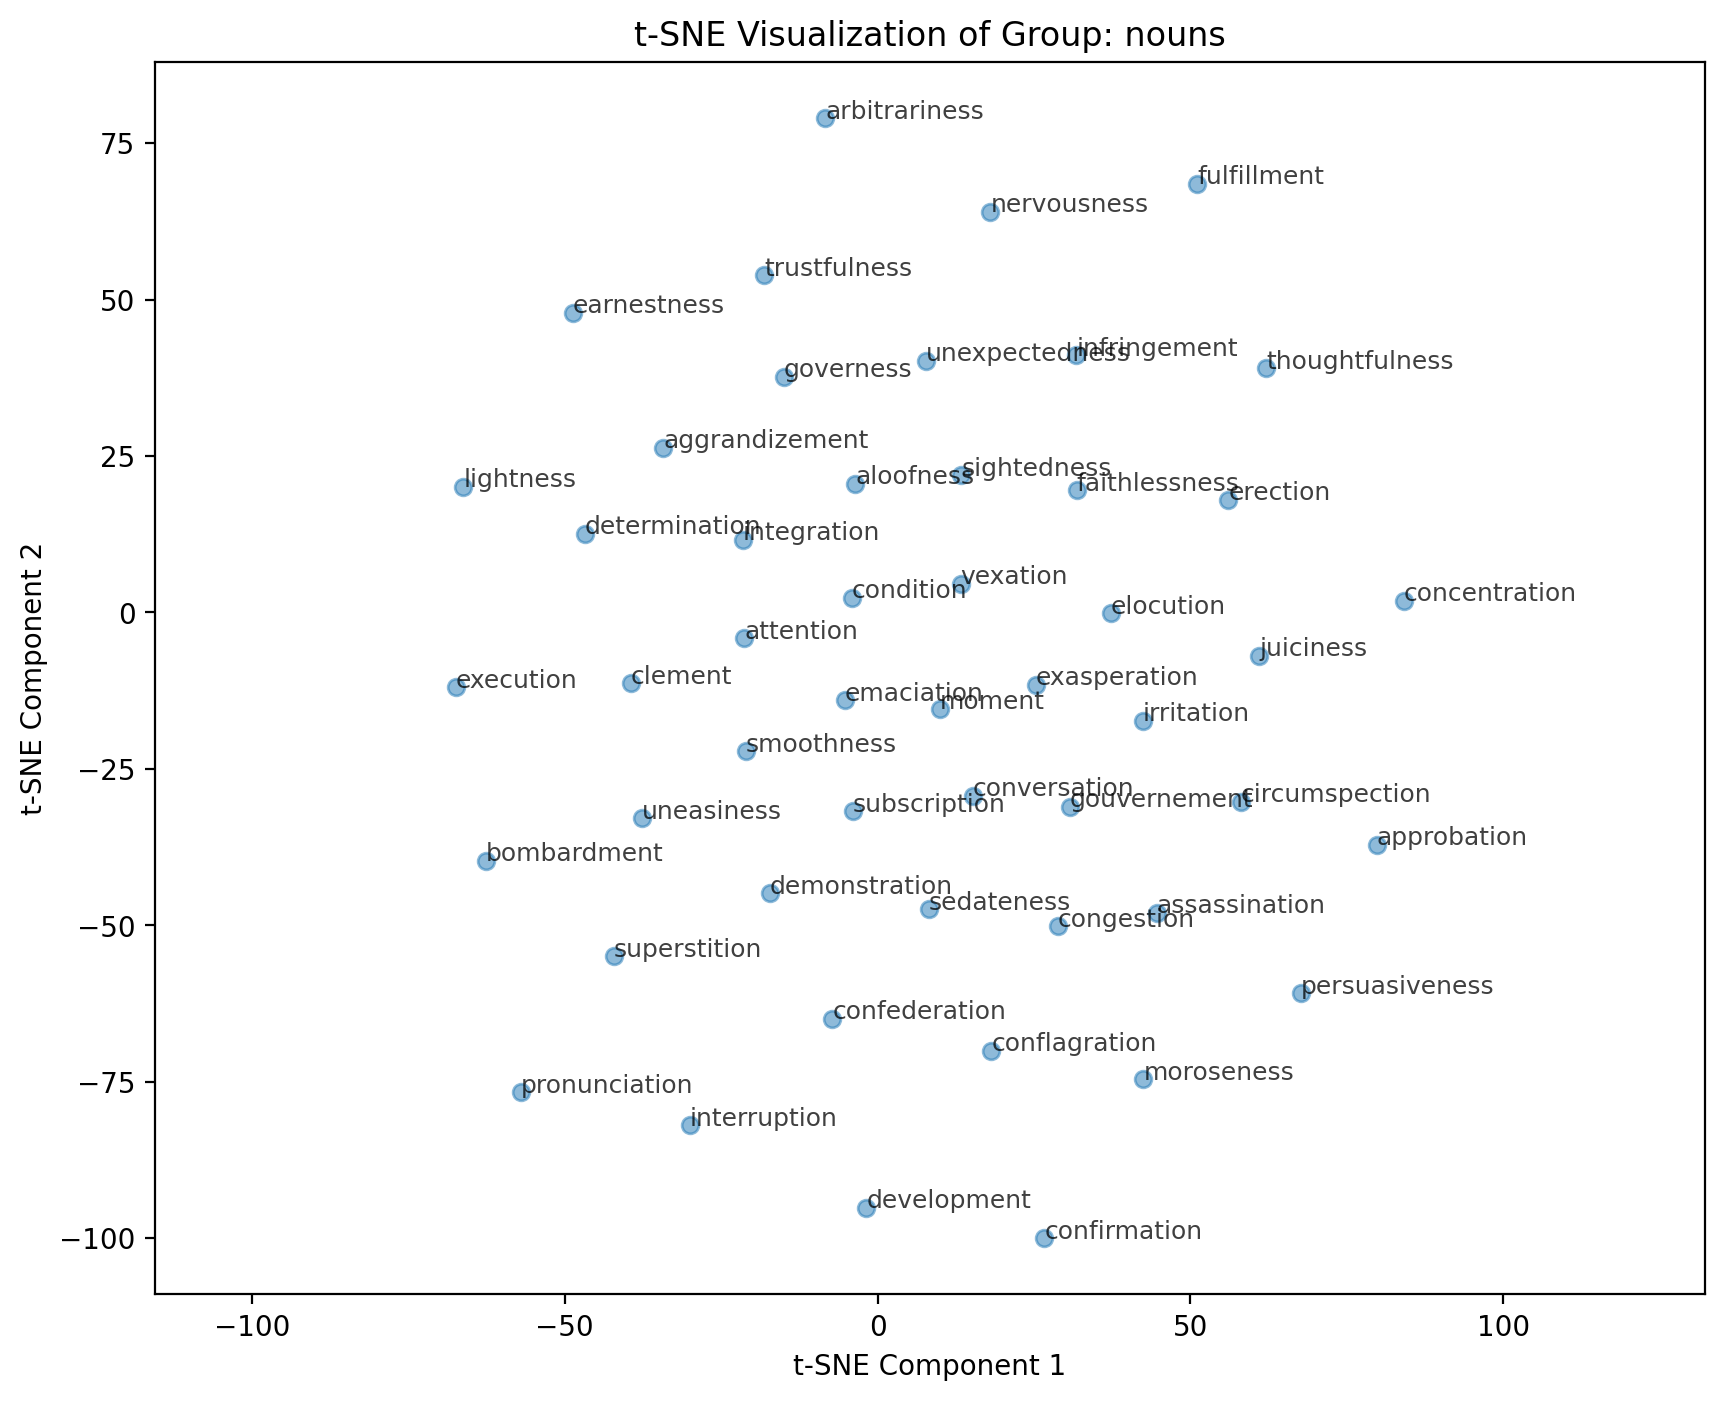

Do you want to proceed to the next group? (y/n):  y


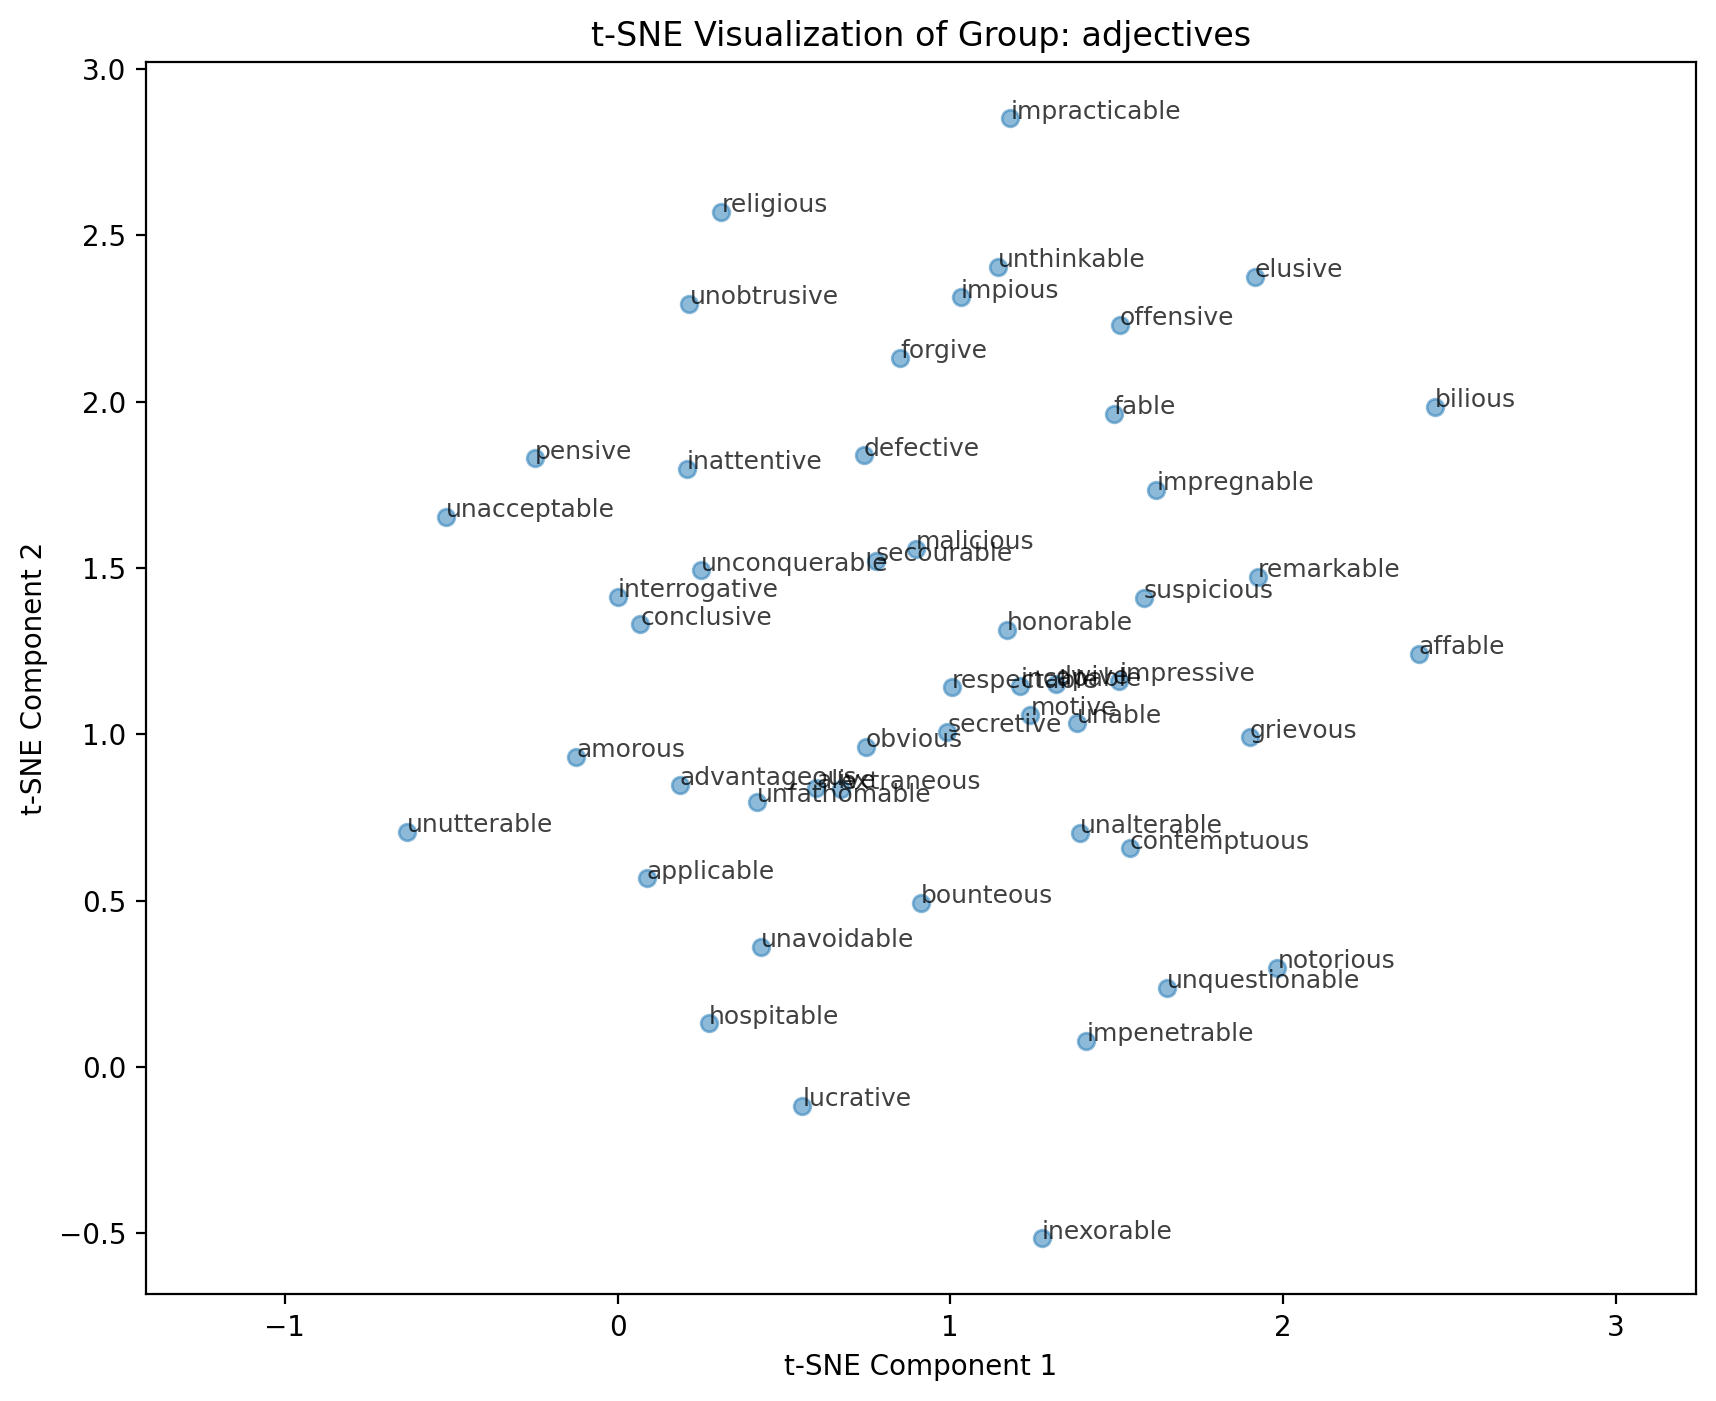

Do you want to proceed to the next group? (y/n):  y


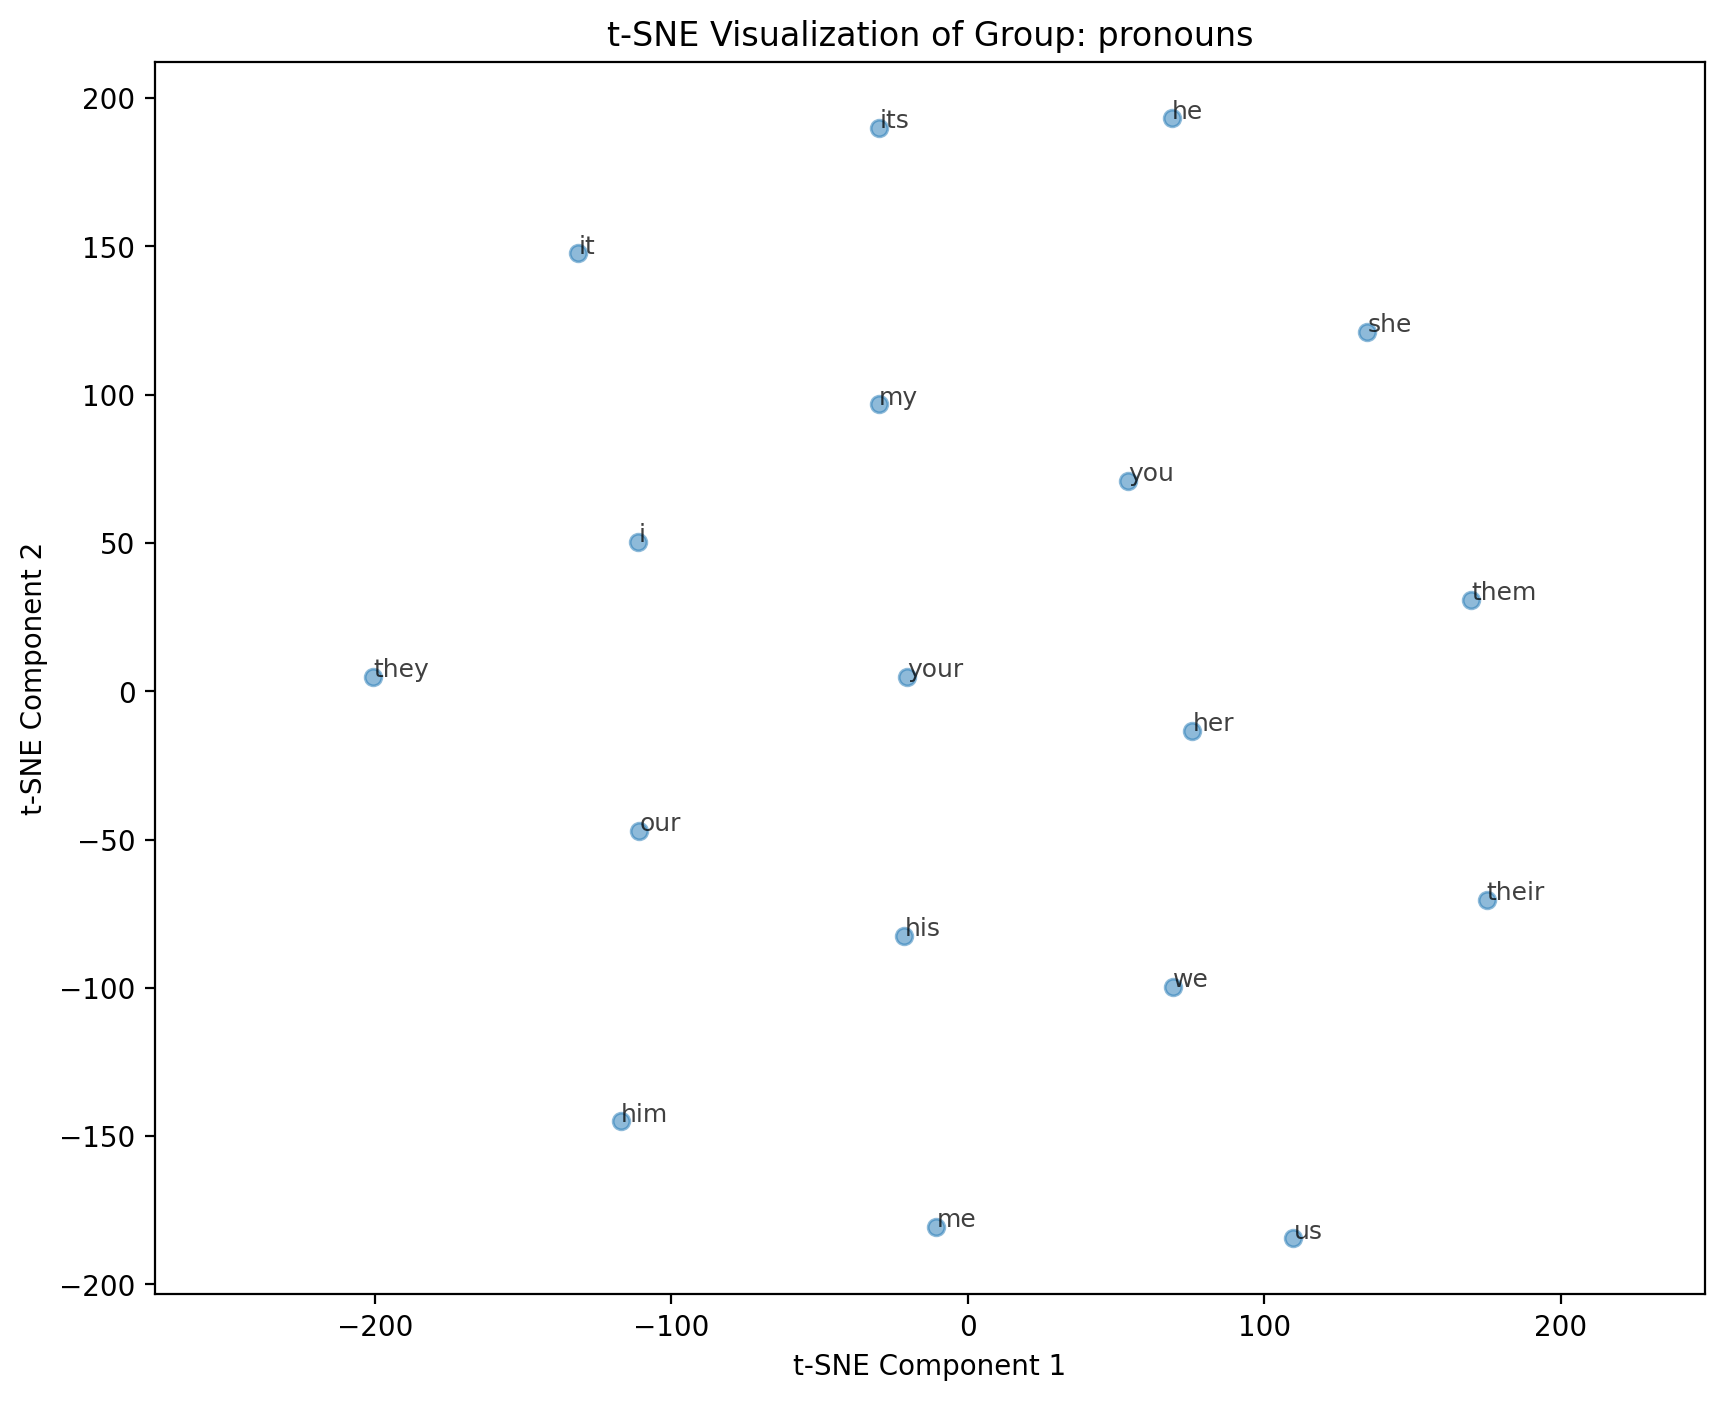

Do you want to proceed to the next group? (y/n):  y


In [54]:
import re
import random
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Group words based on their suffixes
def group_words(itos):
    groups = {
        'verbs_ing': [],
        'verbs_ed': [],
        'adverbs_ly': [],
        'nouns': [],
        'adjectives': [],
        'pronouns': ['i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'],
    }

    # Iterate over all words
    for word in itos.values():
        # Verbs ending with 'ing'
        if word.endswith('ing'):
            groups['verbs_ing'].append(word)
        # Verbs ending with 'ed'
        elif word.endswith('ed'):
            groups['verbs_ed'].append(word)
        # Adverbs ending with 'ly'
        elif word.endswith('ly'):
            groups['adverbs_ly'].append(word)
        # Nouns: words ending with common noun suffixes
        elif word.endswith('ness') or word.endswith('ment') or word.endswith('tion'):
            groups['nouns'].append(word)
        # Adjectives: words ending with common adjective suffixes
        elif word.endswith('able') or word.endswith('ous') or word.endswith('ive'):
            groups['adjectives'].append(word)

    return groups

pronouns = ['he', 'she', 'they', 'we', 'i', 'you', 'it', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'its', 'their', 'our']

grouped_words = group_words(itos)
grouped_words['pronouns'] = [word for word in pronouns if word in stoi]
print(f"Number of pronouns: {len(grouped_words['pronouns'])}")

# Select a subset of words for each group (e.g., 50 from each group)
num_words_per_group = 50

for group_name, group in grouped_words.items():
    selected_words = random.sample(group, min(num_words_per_group, len(group)))
    
    # Extract the embeddings for the selected words
    selected_embeddings = []
    selected_word_labels = []
    
    for word in selected_words:
        if word in stoi:  # Ensure the word exists in stoi
            idx = stoi[word]  # Get the index of the word
            selected_embeddings.append(embedding_weights[idx])  # Get the embedding
            selected_word_labels.append(word)  # Save the word for labeling
    
    selected_embeddings = torch.tensor(selected_embeddings)  # Convert to tensor
    n_samples = selected_embeddings.shape[0]
    
    # Reduce dimensionality using t-SNE
    perplexity_value = min(30, n_samples - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=1)
    embeddings_tsne = tsne.fit_transform(selected_embeddings)
    
    # Plot the selected words' embeddings
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
    
    # Annotate the plot with the corresponding words
    for i, word in enumerate(selected_word_labels):
        plt.annotate(word, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), fontsize=9, alpha=0.75)
    
    plt.title(f't-SNE Visualization of Group: {group_name}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')

    # Set equal scaling
    plt.axis('equal')  # This will make the axes have the same scale
    
    plt.show()
    
    # Ask user if they want to visualize the next group
    user_input = input(f"Do you want to proceed to the next group? (y/n): ")
    if user_input.lower() != 'y':
        break


In [55]:
grouped_words

{'verbs_ing': ['applauding',
  'cleaving',
  'remaining',
  'puffing',
  'adducing',
  'bickering',
  'claiming',
  'occurring',
  'blessing',
  'disdaining',
  'chatting',
  'drumming',
  'leaking',
  'justifying',
  'bearing',
  'overtaking',
  'attacking',
  'teasing',
  'nudging',
  'recruiting',
  'crashing',
  'gladdening',
  'interlarding',
  'snapping',
  'snuffling',
  'catching',
  'forgiving',
  'reckoning',
  'lingering',
  'alienating',
  'wasting',
  'occupying',
  'suppressing',
  'retrieving',
  'esteeming',
  'readjusting',
  'sobbing',
  'ailing',
  'hallooing',
  'regenerating',
  'conveying',
  'rigging',
  'perplexing',
  'feeling',
  'adding',
  'fascinating',
  'scathing',
  'pawing',
  'obtaining',
  'signifying',
  'dancing',
  'harming',
  'nourishing',
  'bisecting',
  'perceiving',
  'sealing',
  'whirring',
  'appreciating',
  'saving',
  'footing',
  'unceasing',
  'crouching',
  'recurring',
  'eddying',
  'foundling',
  'beekeeping',
  'scolding',
  'coo

In [56]:
# Join the list into a single space-separated string
words_text = " ".join(words)

# Define the file path
file_path = "/kaggle/working/words_list.txt"

# Write the string to a text file
with open(file_path, "w") as file:
    file.write(words_text)

print(f"File saved at: {file_path}")

File saved at: /kaggle/working/words_list.txt


1. evoked - unevoked
2. ordered - disordered
3. likely - unlikely
4. connected - disconnected
5. hindered - unhindered
6. affected - unaffected
7. experience - inexperience

1. rejoice - delight
2. foretell - predict
3. glided - slid
4. endanger - jeopardize
5. flee - escape

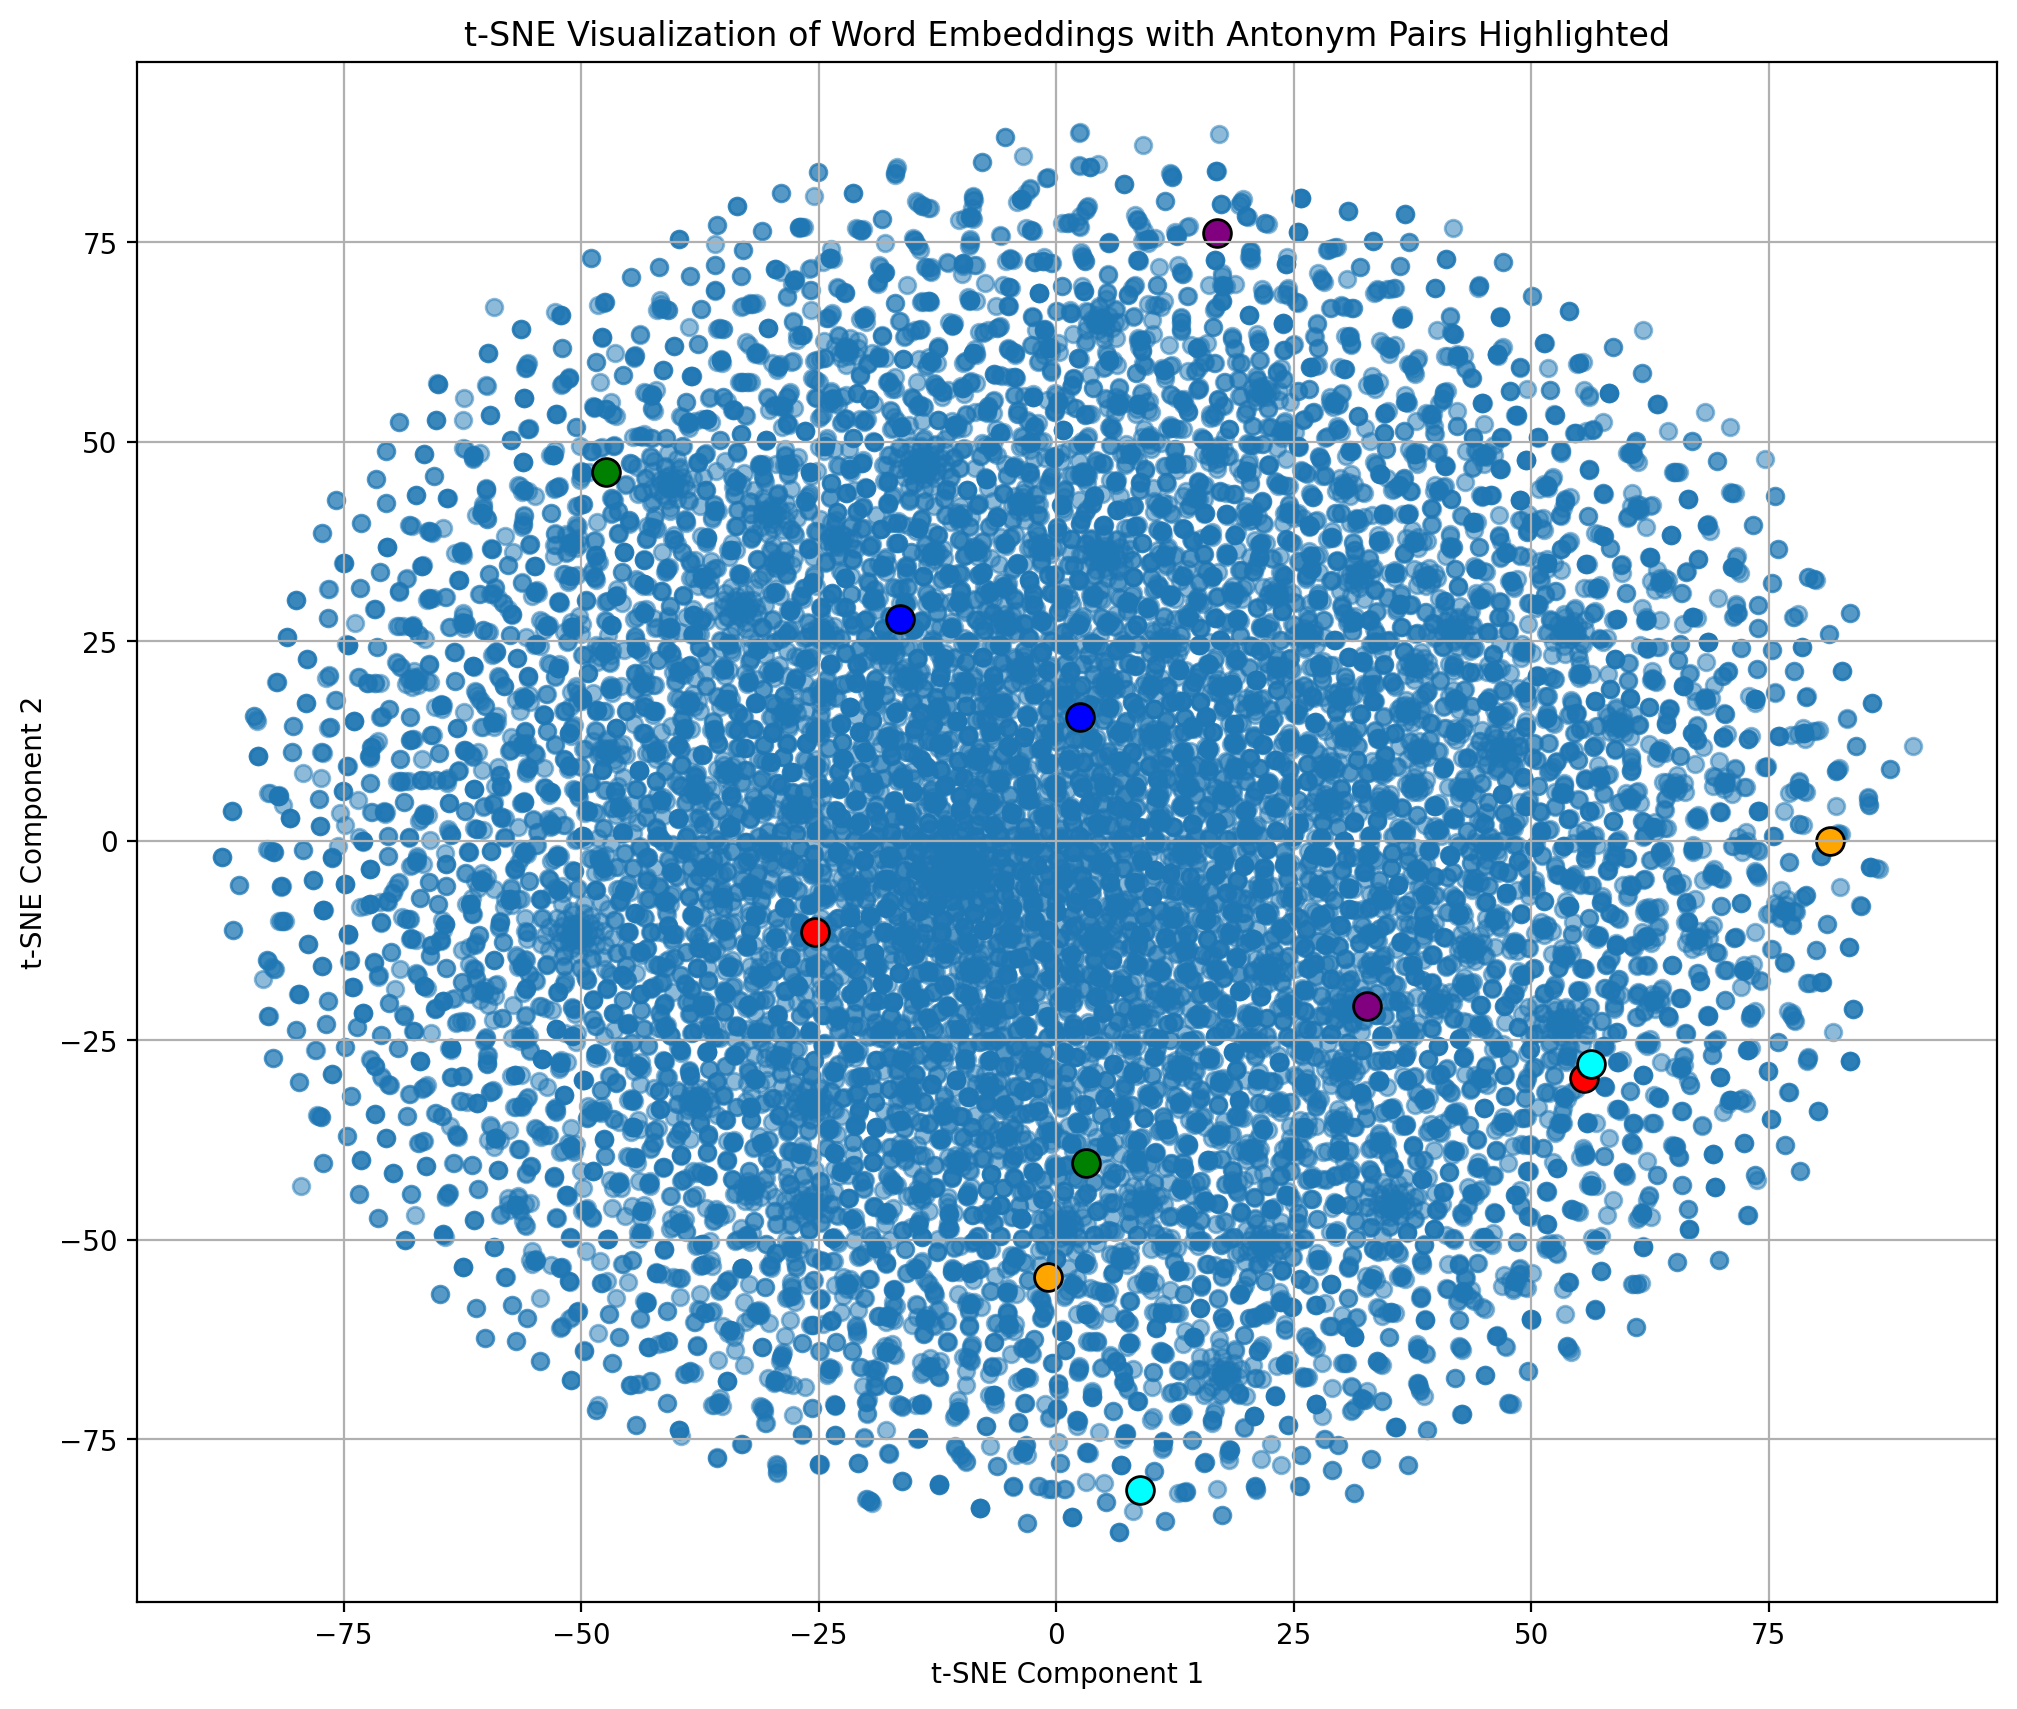

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'model' is your trained model and 'stoi' is your word-to-index mapping
antonym_pairs = [
    ("evoked", "unevoked"),
    ("ordered", "disordered"),
    ("likely", "unlikely"),
    ("connected", "disconnected"),
    ("hindered", "unhindered"),
    ("experience", "inexperience")
]

# Define a list of colors for each antonym pair
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']

# Get embeddings for antonym pairs
word_embeddings = []
words = []  # To store the words separately

for word1, word2 in antonym_pairs:
    idx1 = stoi.get(word1)
    idx2 = stoi.get(word2)

    if idx1 is not None and idx2 is not None:
        # Get embeddings
        embedding1 = model.emb.weight[idx1].detach().cpu().numpy()
        embedding2 = model.emb.weight[idx2].detach().cpu().numpy()
        
        word_embeddings.append(embedding1)
        word_embeddings.append(embedding2)

        words.append(word1)  # Store first word
        words.append(word2)  # Store second word
    else:
        print(f"One of the words '{word1}' or '{word2}' is not in the vocabulary.")

# Get embeddings for all words in vocabulary
all_words = list(stoi.keys())
all_word_embeddings = [model.emb.weight[stoi[word]].detach().cpu().numpy() for word in all_words]

# Convert to numpy arrays
word_embeddings = np.array(word_embeddings)
all_word_embeddings = np.array(all_word_embeddings)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_tsne = tsne.fit_transform(all_word_embeddings)

# Create a mapping from embeddings to words
word_to_embedding = {word: emb for word, emb in zip(all_words, embeddings_tsne)}

# Visualize embeddings
plt.figure(figsize=(12, 10))

# Scatter all words
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5, label='All Words')

# Highlight antonym pairs with the same color
for idx, (word1, word2) in enumerate(antonym_pairs):
    if word1 in stoi and word2 in stoi:
        emb1 = word_to_embedding[word1]
        emb2 = word_to_embedding[word2]
        color = colors[idx % len(colors)]  # Cycle through colors

        # Plot both words in the antonym pair with the same color
        plt.scatter(emb1[0], emb1[1], color=color, edgecolor='black', s=100)
        plt.scatter(emb2[0], emb2[1], color=color, edgecolor='black', s=100)

# # Annotate all words
# for i, word in enumerate(all_words):
#     plt.annotate(word, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), 
#                  textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('t-SNE Visualization of Word Embeddings with Antonym Pairs Highlighted')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()


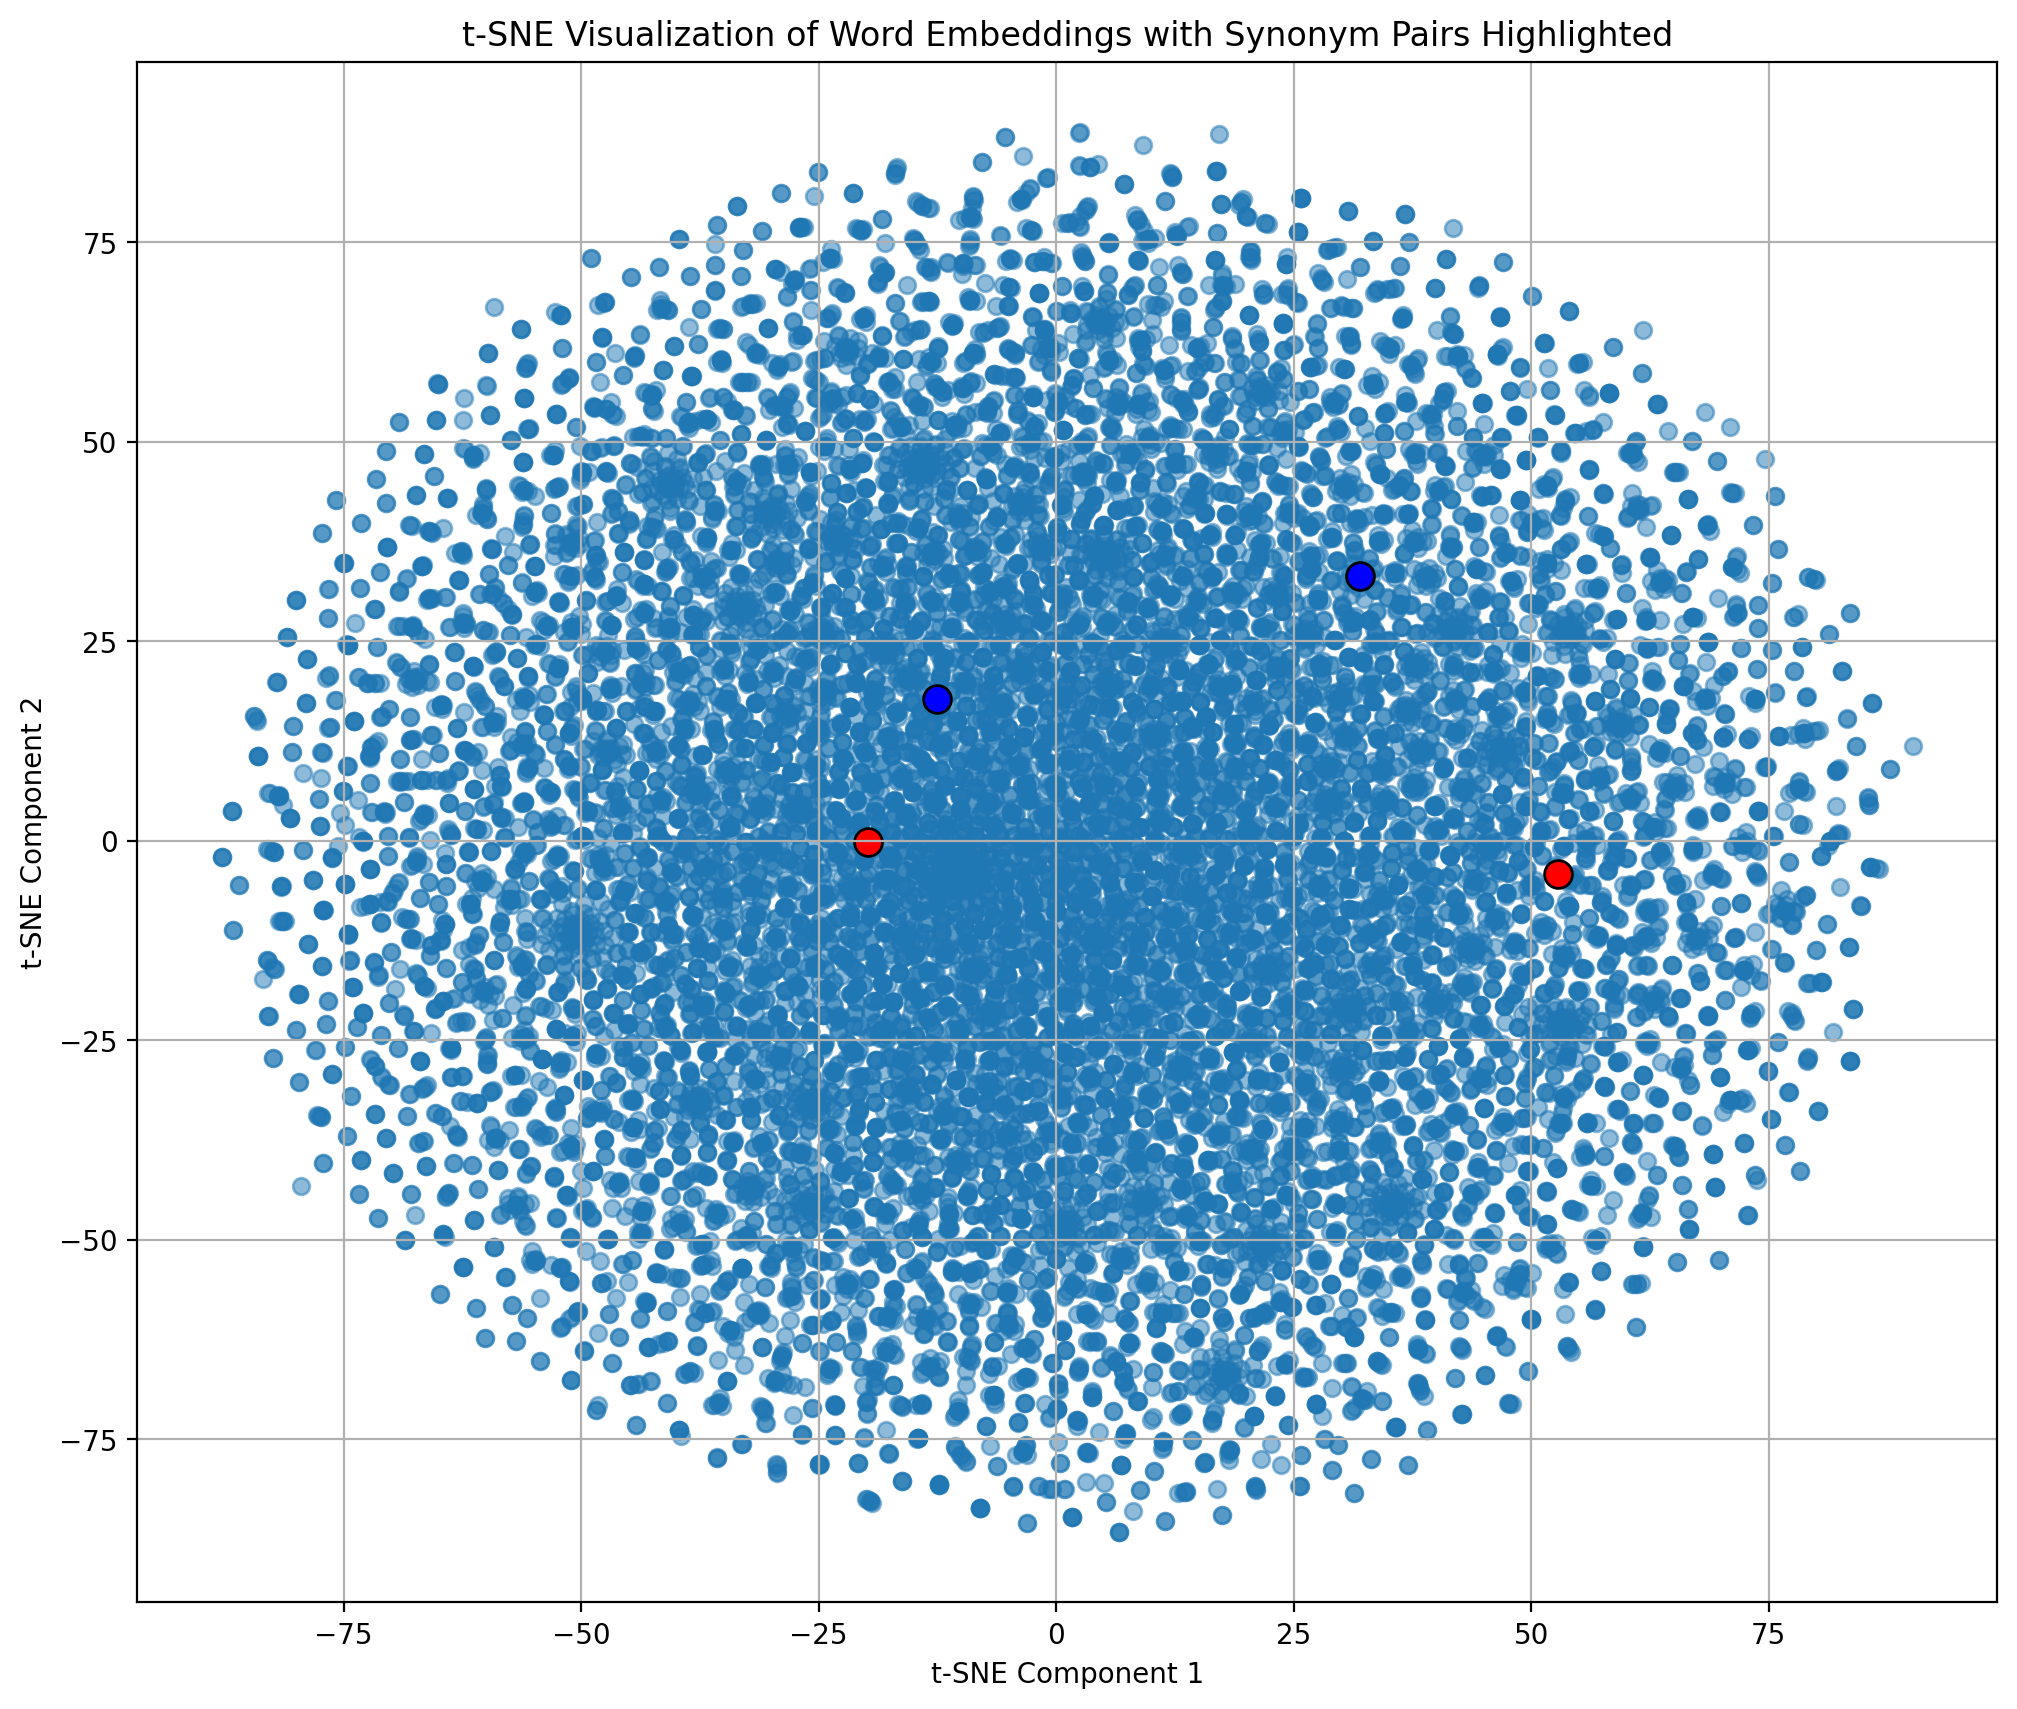

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'model' is your trained model and 'stoi' is your word-to-index mapping
synonym_pairs = [
    ("rejoice", "delight"),
    ("flee", "escape")
]

# Define a list of colors for each synonym pair
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Get embeddings for synonym pairs
word_embeddings = []
words = []  # To store the words separately

for word1, word2 in synonym_pairs:
    idx1 = stoi.get(word1)
    idx2 = stoi.get(word2)

    if idx1 is not None and idx2 is not None:
        # Get embeddings
        embedding1 = model.emb.weight[idx1].detach().cpu().numpy()
        embedding2 = model.emb.weight[idx2].detach().cpu().numpy()
        
        word_embeddings.append(embedding1)
        word_embeddings.append(embedding2)

        words.append(word1)  # Store first word
        words.append(word2)  # Store second word
    else:
        print(f"One of the words '{word1}' or '{word2}' is not in the vocabulary.")

# Get embeddings for all words in vocabulary
all_words = list(stoi.keys())
all_word_embeddings = [model.emb.weight[stoi[word]].detach().cpu().numpy() for word in all_words]

# Convert to numpy arrays
word_embeddings = np.array(word_embeddings)
all_word_embeddings = np.array(all_word_embeddings)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_tsne = tsne.fit_transform(all_word_embeddings)

# Create a mapping from embeddings to words
word_to_embedding = {word: emb for word, emb in zip(all_words, embeddings_tsne)}

# Visualize embeddings
plt.figure(figsize=(12, 10))

# Scatter all words
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5, label='All Words')

# Highlight synonym pairs with the same color
for idx, (word1, word2) in enumerate(synonym_pairs):
    if word1 in stoi and word2 in stoi:
        emb1 = word_to_embedding[word1]
        emb2 = word_to_embedding[word2]
        color = colors[idx % len(colors)]  # Cycle through colors

        # Plot both words in the synonym pair with the same color
        plt.scatter(emb1[0], emb1[1], color=color, edgecolor='black', s=100)
        plt.scatter(emb2[0], emb2[1], color=color, edgecolor='black', s=100)

# Annotate all words (optional)
# for i, word in enumerate(all_words):
#     plt.annotate(word, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), 
#                  textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('t-SNE Visualization of Word Embeddings with Synonym Pairs Highlighted')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()
